Verhaallijn: 

Ons idee was om de data van de bushaltes doorheen antwerpen te vergelijken met de hogescholen gelegen in antwerpen.
Waarom wouden we dit doen? Dit kan voor veel verschillende mensen practisch zijn. Een groot aantal mensen die de bus nemen zijn studenten. Natuurlijk wilt de lijn en de gemeente Antwerpen ervoor zorgen dat iedereen hier zou geraken met het openbaar vervoer. Voor studenten kan dit ook practisch zijn om verscheiden haltes te bekijken op de kaart en de scholen waar zij potentiël willen gaan studeren. 

Om dat te kunnen doen hebben we eerst de data moeten zoeken. Deze vonden we op de website van de FOD. Die lezen we als eerste in. 

Daarna wouden we duidelijk maken waar alle campussen van alle verschillende hogescholen zijn. Zo konden we al zien van uit welke gemeentes uit de provincie Antwerpen je kan komen naar Antwerpen.

We wouden de hogescholen met elkaar vergelijken. We wouden bekijken hoeveel campussen elke hogeschool had en waar de meeste gelegen waren.Vooralleer we dit konden doen moesten we onze data in een RDD (Resilient Distributed Dataset) plaatsen. Door gebruik te maken van een sql query en een mathplot konden we deze gegevens weergeven in een grafiek. 
-> conclusie van de grafieken toevoegen

Natuurlijk wil je dan je halte thuis kunnen vinden, dit gaat! Door je gemeente in te geven, kan je alle haltes op de kaart bekijken. En eens dat je jouw school gekozen hebt kan je ook alle haltes in de buurt van jouw school bekijken.

# Laden van data

In [1]:
import numpy as np
import folium
from folium import plugins
from datetime import datetime
from pyspark.sql import SQLContext
from pyspark.sql.types import *
import findspark 
findspark.find()
import pyspark
from pyspark import SparkContext
sc = pyspark.SparkContext(appName="Scholen")
from pyspark.sql.functions import countDistinct
sqlContext = SQLContext(sc)
from pyspark.sql import Row
import matplotlib.pyplot as plt
from ipywidgets import widgets
from IPython.display import clear_output

#locatie file, inlezen en verzamelen.
data_file = "./hoger_onderwijs_overzicht.csv"
school_data = sc.textFile(data_file).filter(lambda l : 'id' not in l)
school = school_data.collect()

data_file_stop = "./stops.csv"
stops_data = sc.textFile(data_file_stop).filter(lambda l : 'stop_id' not in l)
stops = stops_data.collect()

data_file_route = "./routes.csv"
route_data = sc.textFile(data_file_route).filter(lambda l : 'route_id' not in l)
route = route_data.collect()

data_file_fullstop = "./fullstops.csv"
fullstops_data = sc.textFile(data_file_fullstop).filter(lambda l : 'stop_id' not in l)
fullstops = fullstops_data.collect()

# Bus stops en Hogescholen

## Alle campussen & 1 halte per gemeente

In [5]:
#map inladen (startlocatie en zoom)
a = folium.Map([51.260197, 4.402771], zoom_start=10)

#alle scholen toevoegen aan de kaart
for row in school:
    arr_row = row.split(',')
    lat = float(arr_row[1])
    lon = float(arr_row[0])
    folium.Marker(location=[float(lat), float(lon)],
                popup=arr_row[6],
                icon=folium.Icon(color='red')
                ).add_to(a)
    
#alle haltes toevoegen aan de kaart
for row in stops:
    arr_row = row.split(',')
    lat = float(arr_row[5])
    lon = float(arr_row[6])
    folium.Marker(location=[float(lat), float(lon)],
                popup=arr_row[2],
                icon=folium.Icon(color='blue')
                ).add_to(a)
#kaart printen
a

## Hoeveel campussen per hogeschool

In [2]:
#RDD aanmaken van school
school_data_rdd = school_data.map(lambda row : row.split(","))
parsed_rdd = school_data_rdd.map(lambda r: Row(
    X =float (r[0]),
    Y =float (r[1]),
    id =r[2],
    thema =r[3],
    type=r[4],
    straat=r[5],
    huisnummer=int (r[6]),
    postcode=r[7],
    district=r[8],
    naam=r[9],
    campusnaam=r[10]
    ))

df = sqlContext.createDataFrame(parsed_rdd)
df.registerTempTable("scholen")


In [3]:
#sql query alle scholen en count
total_schoolscount = sqlContext.sql("""
                           SELECT naam,count(*) as total
                           FROM scholen
                           GROUP BY naam
                           """)

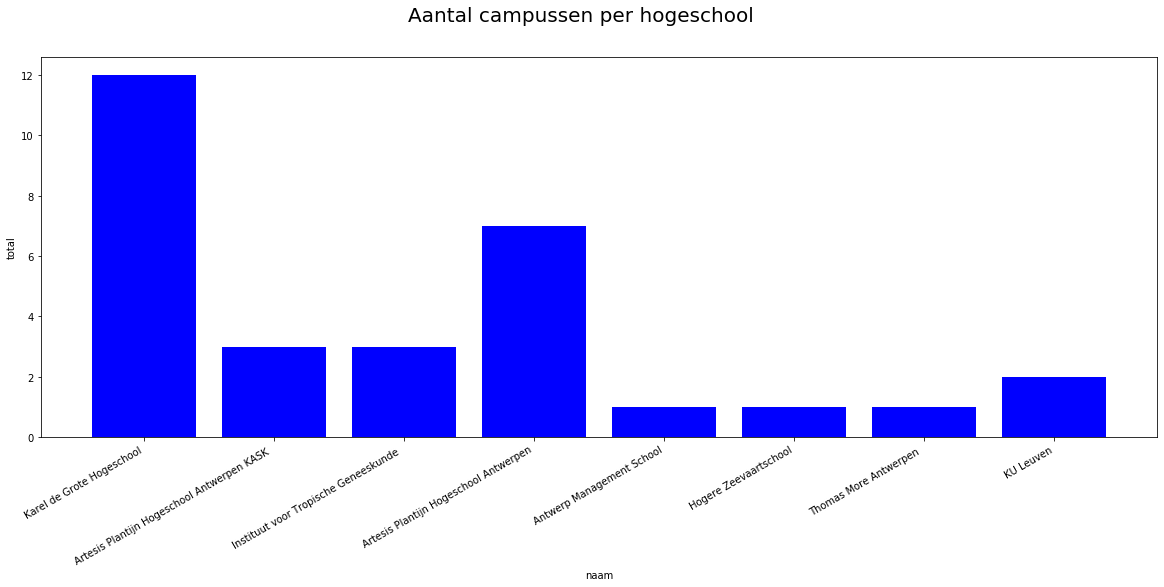

In [4]:
#grafiek alle scholen en count
%matplotlib inline
y_axis = []
x_axis = []

for i in range(0, 8):
    #y as de namen ophalen 
    y_axis.append(total_schoolscount.collect()[i][0])
    #x as de count ophalen
    x_axis.append(total_schoolscount.collect()[i][1])

fig2 = plt.figure(figsize=(20, 7))
fig2.suptitle('Aantal campussen per hogeschool', fontsize=20)
ax = fig2.add_subplot(111)
ax.set_xlabel('naam')
ax.set_ylabel('total')
ax.bar(y_axis,x_axis, align='center', color='blue')
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.show()

## Aantal campussen per postcode

In [6]:
#sql query aantal scholen per postcode
total_schools_zip = sqlContext.sql("""
                           SELECT postcode, count(*) as total
                           FROM scholen
                           GROUP BY  postcode
                           """)

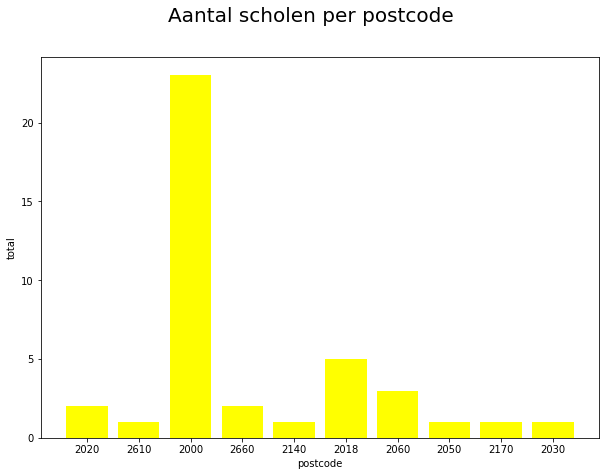

In [7]:
#grafiek aantal scholen per postcode
%matplotlib inline
y_axis = []
x_axis = []

for i in range(0, 10):
    #y as de postcode ophalen
    y_axis.append(total_schools_zip.collect()[i][0])
    #x as de count ophalen
    x_axis.append(total_schools_zip.collect()[i][1])

fig2 = plt.figure(figsize=(10, 7))
fig2.suptitle('Aantal scholen per postcode', fontsize=20)
ax = fig2.add_subplot(111)
ax.set_xlabel('postcode')
ax.set_ylabel('total')
ax.bar(y_axis,x_axis, color='yellow')
plt.show()


2000 -Antwerpen

2018 -Antwerpen 1 (gebied tussen de Leien, Gemeente-en Carnotstraat en Singel)

2020 -Antwerpen 2 (Kiel)

2030 -Antwerpen 3 (Luchtbal)

2050 -Antwerpen 5 (Linkeroever)

2060 -Antwerpen 6 (Seefhoek)

2140 -Borgerhout

2170 -Merksem

2660 -Hoboken

2610 -Wilrijk



<img src="antwerpen.png" alt="drawing" width="300" align="left"/>

## Aantal stops per gemeente

In [8]:
#rdd aanmaken van stops
fullstops_data_rdd = fullstops_data.map(lambda row : row.split(";"))
parsed_rdd = fullstops_data_rdd.map(lambda r: Row(
    id =r[0],
    name=r[2],
    X =float (r[4]),
    Y =float (r[5])
    )
)
df = sqlContext.createDataFrame(parsed_rdd)
df.registerTempTable("stops")

In [9]:
# widget aantal stops per gemeente
text = widgets.Text()
text.value='Merksem'
button = widgets.Button(description="Zoek")

display(text)
display(button)

Text(value='Merksem')

Button(description='Zoek', style=ButtonStyle())

In [10]:
def on_button_clicked(b):
    #clear_output()
    #sql queries 
    stmt_count = """SELECT count(*) as total
                    FROM stops
                    WHERE name LIKE '%""" + text.value.capitalize() + "%'"
        
    stmt = """SELECT name, X, Y
              FROM stops
              WHERE name LIKE '%""" + text.value.capitalize() + "%'"
    
    #printen van aantal stops
    total_stops = sqlContext.sql(stmt_count)
    total_stops.show()
    
    #tonen van aantal stops per gemeente op de kaart
    a = folium.Map([51.21989, 4.40346], zoom_start=10)
        
    total_stops = sqlContext.sql(stmt)
    array_stops = np.array(total_stops.select("name","X","Y").collect())   
        
    for row in array_stops:
        folium.Marker(location=[float(row[1]), float(row[2])],
                popup=row[0],
                icon=folium.Icon(color='blue')
                ).add_to(a)
    display(a)
    
button.on_click(on_button_clicked)

## Haltes op de kaart per hogeschool

In [11]:
#widget instituut 
dropdown = widgets.Dropdown(
    options={'Artesis Plantijn':'Artesis', 
             'Karel de groote':'Karel', 
             'Universiteit Antwerpen':'Universiteit',
             'Thomas More':'Thomas',
             'Instituut van zeevaart':'Instituut',
             'Hogere Zeevaartschool':'Hogere',
             'KU Leuven':'KU'},
    value='KU',
    description='School:',
    disabled=False,
)

button = widgets.Button(description="Zoek")

display(dropdown)
display(button)

Dropdown(description='School:', index=6, options={'Artesis Plantijn': 'Artesis', 'Karel de groote': 'Karel', '…

Button(description='Zoek', style=ButtonStyle())

In [12]:
#functie kaart tonen 
def on_button_clicked(b):
    
    stmt = """SELECT naam, X, Y
            FROM scholen
            WHERE naam LIKE '%""" + dropdown.value.capitalize() + "%'"
    
    stmt2 = """SELECT name, X, Y FROM stops
                WHERE name LIKE '%Antwerpen%'"""
    
    a = folium.Map([51.21989, 4.40346], zoom_start=14)
    
    total_schools = sqlContext.sql(stmt)
    array_schools = np.array(total_schools.select("naam","X","Y").collect())
    
    total_stops = sqlContext.sql(stmt2)
    array_stops = np.array(total_stops.select("name","X","Y").collect())
    
    for row in array_schools:
        folium.Marker(location=[float(row[2]), float(row[1])],
                popup=row[0],
                icon=folium.Icon(color='red')
                ).add_to(a)
        
    for row in array_stops:
        folium.Marker(location=[float(row[1]), float(row[2])],
                popup=row[0],
                icon=folium.Icon(color='blue')
                ).add_to(a)
    display(a)
    
button.on_click(on_button_clicked)